## Computing gini impurity for Breast cancer classification

In [36]:
import numpy as np

def compute_gini(class_frequencies):
    probabilities = class_frequencies / np.sum(class_frequencies)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

class_dist_matrix = np.array([
    [150, 0],
    [10, 90],
    [60, 40],
    [50, 50]
])

for num_cases in range(len(class_dist_matrix)):
    class_dist = class_dist_matrix[num_cases,:]
    gini_impurity = compute_gini(class_dist)
    print("{:.2f}".format(gini_impurity))

0.00
0.18
0.48
0.50


## Decision tree implementation with python from scratch

In [37]:
# Let's import the necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import datasets

iris = datasets.load_iris()

# convert the data into dataframe
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data.head()

feature_names, class_names = iris.feature_names, iris.target_names
print("Feature Names:", feature_names)
print("Target Names:", class_names)

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


In [38]:
# Function to split dataset into train and test set
def train_test_split(df, test_size):
  if isinstance(test_size, float):
      test_size = round(test_size * len(df))

  indices = df.index.tolist()
  test_indices = random.sample(population=indices, k=test_size)

  test_df = df.loc[test_indices]
  train_df = df.drop(test_indices)

  return train_df, test_df

In [39]:
# let's try the function to split into train and test from above data
random.seed(0)  # Ensures same reproducibility
train_df, test_df = train_test_split(data, test_size=20)
train_df.shape, test_df.shape

((130, 5), (20, 5))

## Helper Functions

In [40]:
# function to calculate gini impurity
def compute_gini_metric(data):
  label_column = data[:, -1]
  _ , counts = np.unique(label_column, return_counts=True)
  probabilities = counts/counts.sum()
  gini = 1 - sum(probabilities ** 2)

  return gini

In [41]:
print(compute_gini_metric(train_df.to_numpy()))

0.6660355029585798


In [42]:
# function to compute weighted gini for given nodes
def compute_weighted_gini(left_child, right_child):
  n = len(left_child) + len(right_child)
  p_left_child = len(left_child) / n
  p_right_child = len(right_child) / n

  weighted_gini =  (p_left_child * compute_gini(left_child)
                      + p_right_child * compute_gini(right_child))

  return weighted_gini

In [43]:
# splits the data into two halves given the split values
def split_data(data, split_column, split_value):
  split_column_values = data[:, split_column]

  left_child = data[split_column_values <= split_value]
  right_child = data[split_column_values > split_value]

  return left_child, right_child

In [44]:
# finds out all the potential splits for all feature columns in daytaset 
def get_potential_splits(data):
  potential_splits = {}
  _, n_columns = data.shape
  for column_index in range(n_columns - 1):   # Excluding the last column which is the label
      potential_splits[column_index] = []
      values = data[:, column_index]
      unique_values = np.unique(values)

      for index in range(len(unique_values)):
          if index != 0:
              current_value = unique_values[index]
              previous_value = unique_values[index - 1]
              potential_split = (current_value + previous_value) / 2

              potential_splits[column_index].append(potential_split)

  return potential_splits

# gets the best split with lowest gini impurity
def determine_best_split(data, potential_splits):
  overall_gini = 9999    

  for column_index in potential_splits:
      for value in potential_splits[column_index]:
          data_below, data_above = split_data(data, split_column=column_index, split_value=value)
          current_overall_gini = compute_weighted_gini(data_below, data_above)

          if current_overall_gini <= overall_gini:
              overall_gini = current_overall_gini
              best_split_column = column_index
              best_split_value = value

  return best_split_column, best_split_value

In [45]:
# class to represent Node in a decision tree node
class Node:
  def __init__(self, parent=None, left_child=None, right_child=None, data=None,
              gini=None, label=None, is_leaf=None, split_column=None,
              split_value=None, question=None, depth=None):
    self.parent = parent              
    self.left_child = left_child     
    self.right_child = right_child   
    self.data = data          
    self.label = label            
    self.is_leaf = is_leaf            
    self.split_column = split_column  
    self.split_value = split_value  
    self.question = question     
    self.depth = depth      

  def is_pure(self):     # checks if the node is pure or not
    target = self.data[:, -1]
    unique_classes = np.unique(target)
    if len(unique_classes) == 1:
        return True
    else:
        return False

  def set_label(self):   # assigns a label to a node
    target = self.data[:, -1]
    unique_classes, counts_unique_classes = np.unique(target, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    self.label = classification

In [46]:
# Class to represent Decision tree
class DecisionTree:
  def __init__(self,min_samples=2, max_depth=9999, root=None, features=None):
      self.root = root                # Root node of the decision tree
      self.root.depth = 0             # Depth of root, a constant value set to 0
      self.max_depth = max_depth      # Maximum allowed depth for the decision tree
      self.features = features        # Names of features of the data
      self.min_samples = min_samples  # Minimum samples allowed in a node

  def train_tree(self, node):
      """Recursively trains a decision tree"""
      if node.parent:
          node.depth = node.parent.depth + 1

      if node.is_pure() or len(node.data)<=self.min_samples or node.depth == self.max_depth:
          node.is_leaf = True
          node.set_label()

      else:
          potential_splits = get_potential_splits(node.data)
          split_column, split_value = determine_best_split(node.data,
                                                          potential_splits)

          node.split_column = split_column
          node.split_value = split_value

          data_below, data_above = split_data(node.data, split_column,
                                              split_value)

          node_left = Node(parent=node, data=data_below)
          node_right = Node(parent=node, data=data_above)

          node.left_child = node_left
          node.right_child = node_right
          node.question = "{} <= {}".format(self.features[split_column], split_value)

          self.train_tree(node_left)
          self.train_tree(node_right)

  def predict(self, X):
      """Predicts class label(s) for one or more instances"""
      if X.ndim == 1:
          return self._predict_instance(X)
      else:
          return np.array([self._predict_instance(instance) for instance in X])

  def _predict_instance(self, instance):
      node = self.root
      while not node.is_leaf:
          if instance[node.split_column] <= node.split_value:
              node = node.left_child
          else:
              node = node.right_child
      return node.label


  def get_root(self):
      """Returns the root node of the decision tree"""
      return self.root

In [47]:
root = Node(data=train_df.values)

In [48]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']

my_tree = DecisionTree(root=root, features=features)
my_tree.train_tree(root)

In [49]:
sample = test_df.values[1][:4]
label_test = None           
label_test = my_tree.predict(sample)
print(label_test)

2.0


In [50]:
# let's predict for unseen data
X_test = test_df.iloc[:, :-1].values  # All columns except the last (features)
y_test = test_df.iloc[:, -1].values   # Only the last column (target)

y_pred = my_tree.predict(X_test)
y_pred

array([1., 2., 0., 1., 2., 2., 2., 2., 2., 1., 2., 1., 1., 0., 1., 0., 1.,
       2., 0., 1.])

In [51]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


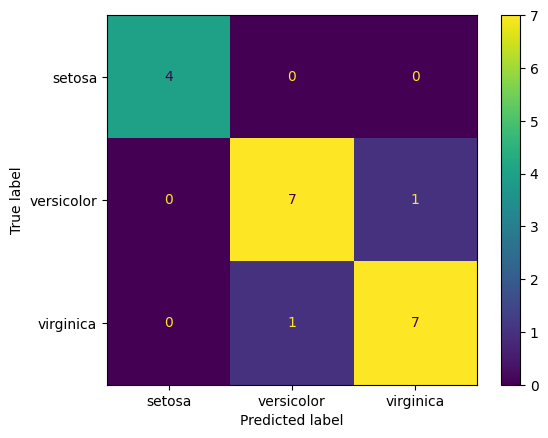

In [52]:
# Plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=class_names)
plt.show()